In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from UNet import UNet  # or from unet import UNetSimple if you prefer the smaller version
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model
from train_test import evaluate_model_sr

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
# import gcm_filters
import random

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [3]:
ds_HR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_HR

<xarray.Dataset> Size: 342GB
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 731)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 6kB 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [4]:
ds_LR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_LR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_LR

<xarray.Dataset> Size: 171GB
Dimensions:       (time: 731, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 6kB 0181-01-01 12:00:00 ... 0200-12-27 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 28GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [5]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

# Robustness Test 1: Random Seed 1
## Remember to restart the kernel each time you do this! Or the tests won't be independent!

In [33]:
torch.manual_seed(1)

In [34]:
# Total number of samples
n_samples = len(ds_HR_reg.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
# np.random.shuffle(indices)     # THIS IS JUST FOR THIS RUN -- VERY NAIVE, DON'T DO THIS OUTSIDE THIS EXPERIMENT

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# HR
train_data_HR = ds_HR_reg.isel(time=train_indices)
val_data_HR = ds_HR_reg.isel(time=val_indices)
test_data_HR = ds_HR_reg.isel(time=test_indices)
# LR
train_data_LR = ds_LR_reg.isel(time=train_indices)
val_data_LR = ds_LR_reg.isel(time=val_indices)
test_data_LR = ds_LR_reg.isel(time=test_indices)

print("Training set size:", len(train_data_HR.time))
print("Validation set size:", len(val_data_HR.time))
print("Testing set size:", len(test_data_HR.time))

Training set size: 511
Validation set size: 109
Testing set size: 111


In [35]:
# Extract HR data
urel_HR_train = train_data_HR.u_relative.values ## training
urel_HR_val = val_data_HR.u_relative.values ## validation
urel_HR_test = test_data_HR.u_relative ## testing

# Extract LR data
urel_LR_train = train_data_LR.u_relative.values ## training
urel_LR_val = val_data_LR.u_relative.values ## validation
urel_LR_test = test_data_LR.u_relative.values ## testing

In [36]:
x_train = torch.tensor(urel_LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(urel_HR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(urel_LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(urel_HR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(urel_LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
# y_test = torch.tensor(urel_HR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [37]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, torch.zeros(len(x_test)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [38]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [39]:
criterion = CombinedLoss(alpha=1) # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_robustnessTrial1.pth',
            n_epochs=10) # n_epochs=2000)

Trainable Parameters: 2314881
Resuming from epoch 10 with best val losses []
Training complete


In [40]:
sr_pred = evaluate_model_sr(model, device, test_loader, urel_HR_test, './model_robustnessTrial1.pth')
sr_pred

Loaded model parameters from ./model_robustnessTrial1.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[-2.7329447e+00, -3.5477228e+00, -4.5553870e+00, ...,
         -3.8198750e+00, -4.4992342e+00, -2.7551837e+00],
        [-3.8947237e+00, -4.1861877e+00, -4.9143720e+00, ...,
         -3.7179503e+00, -5.1461163e+00, -3.0780613e+00],
        [-4.5040703e+00, -4.7925258e+00, -4.6282711e+00, ...,
         -3.7649627e+00, -4.9602637e+00, -3.4750488e+00],
        ...,
        [ 5.8815994e+00,  5.9550953e+00,  5.8190365e+00, ...,
          6.2521744e+00,  1.1966787e+01,  6.0490174e+00],
        [ 6.7940226e+00,  9.0840378e+00,  9.9792004e+00, ...,
          1.0795312e+01,  1.5902103e+01,  8.4396095e+00],
        [ 4.3602576e+00,  5.3156719e+00,  5.3584652e+00, ...,
          6.4639239e+00,  8.1990118e+00,  3.8784223e+00]],

       [[-2.1067657e-02, -1.4377840e-02, -2.0139961e-01, ...,
         -8.5366955e+00, -9.6118803e+00, -6.1734848e+00],
        [-1.3418703e-01, -4.3168189e-03, -2.1406457e-01, ...,
         -8.3571577e+00, -1.0624834e+01, -6.8449893e+00],
        [-2.7912492e-01, -1.2590483e-01, -3.3027977e-01, ...,
         -8.4040184e+00, -1.0285231e+01, -7.3675399e+00],
...
          9.1951147e-02,  9.1951147e-02,  9.1886714e-02],
        [ 5.7328947e-02,  9.1951147e-02,  9.1951147e-02, ...,
          9.1951147e-02,  5.8320679e-02,  7.5125992e-02],
        [ 5.0056349e-02,  5.8663622e-02,  5.9595741e-02, ...,
          2.1511659e-02,  5.1089227e-02,  5.5842545e-02]],

       [[ 9.1951147e-02,  9.1951147e-02,  9.1951147e-02, ...,
         -4.5968814e+00, -5.3750405e+00, -3.3163266e+00],
        [ 9.1951147e-02,  9.1951147e-02,  9.1951147e-02, ...,
         -4.4353628e+00, -6.0337648e+00, -3.6952691e+00],
        [ 9.1951147e-02,  9.1951147e-02,  9.1951147e-02, ...,
         -4.3629227e+00, -5.7081852e+00, -4.0361228e+00],
        ...,
        [-2.7919025e+00, -2.8864920e+00, -3.3557594e+00, ...,
          3.6029243e+00,  7.5639238e+00,  3.6588991e+00],
        [-3.2014484e+00, -3.5915627e+00, -4.4691019e+00, ...,
          6.5599556e+00,  1.0165941e+01,  5.2691774e+00],
        [-2.0699394e+00, -2.5372047e+00, -3.3565650e+00, ...,
          3.9820826e+00,  5.2038178e+00,  2.4035342e+00]]],
      shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0197-12-23 12:00:00 ... 0200-12-27 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

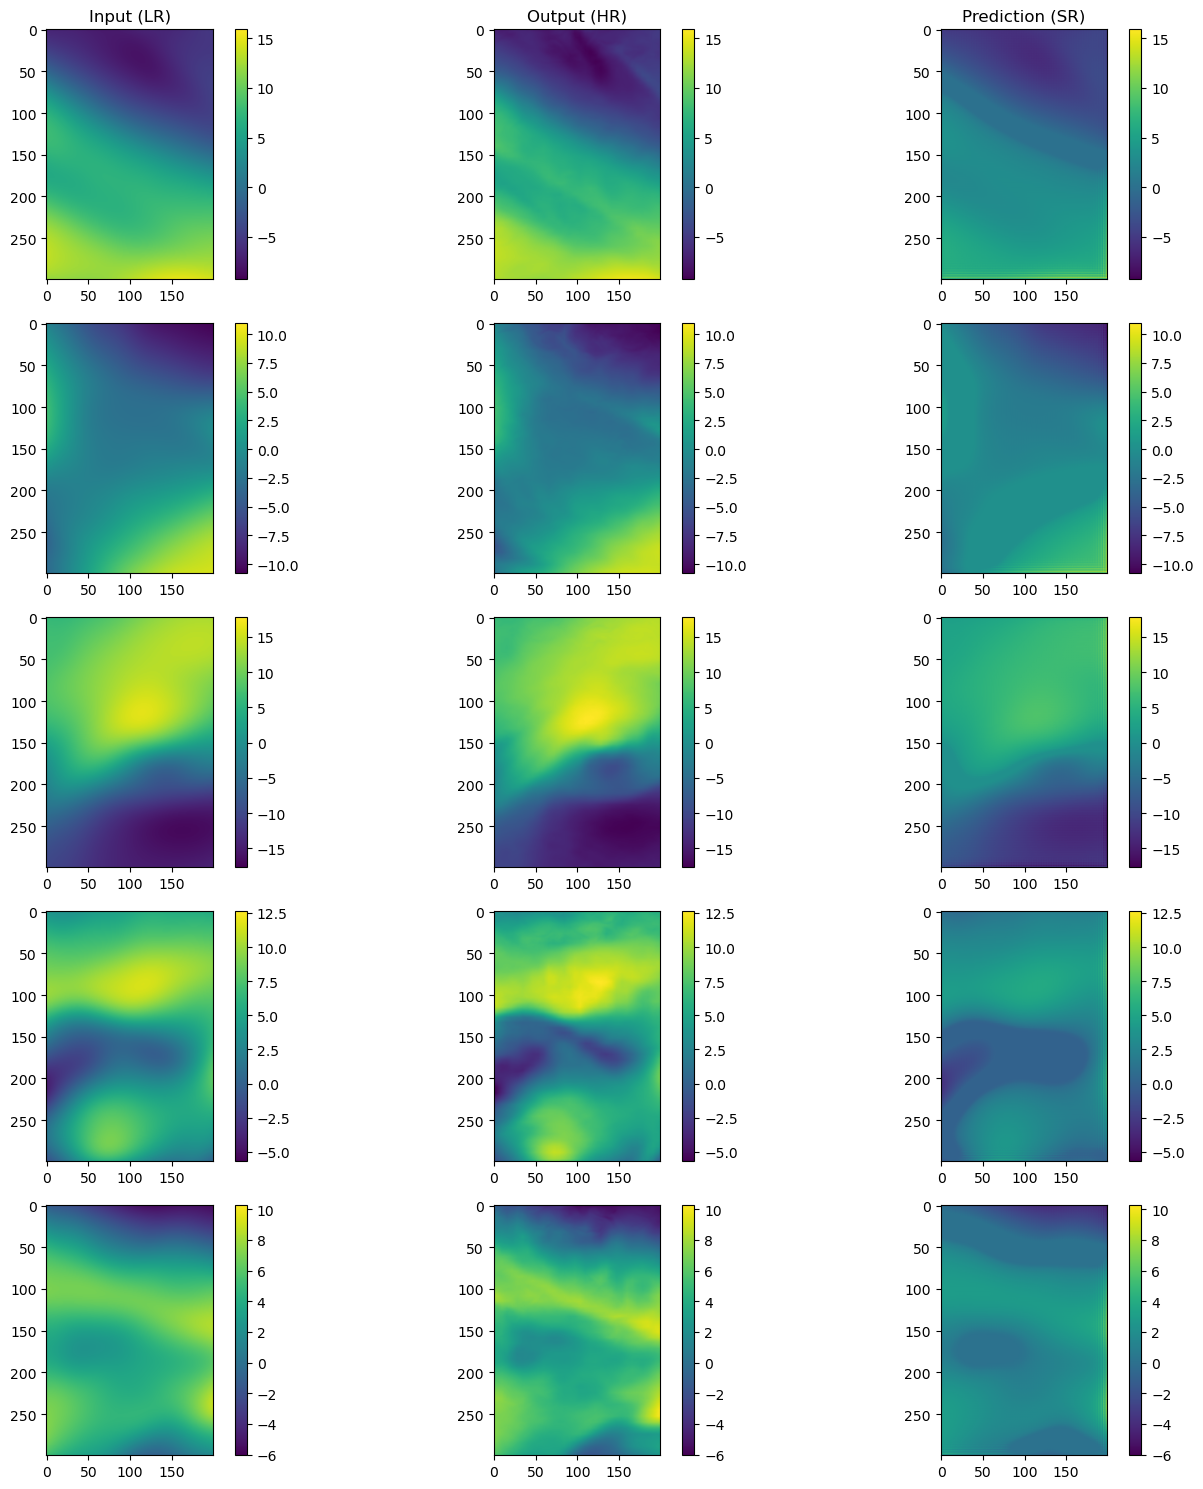

In [41]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = urel_LR_test[i,:,:] 
    d2 = urel_HR_test[i,:,:]
    d3 = sr_pred[i,:,:]

    # Min/Max Calculation
    vmin = min(d1.min().item(), d2.min().compute().item(), d3.min().compute().item())
    vmax = max(d1.max().item(), d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('Output (HR)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 2].set_title('Prediction (SR)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

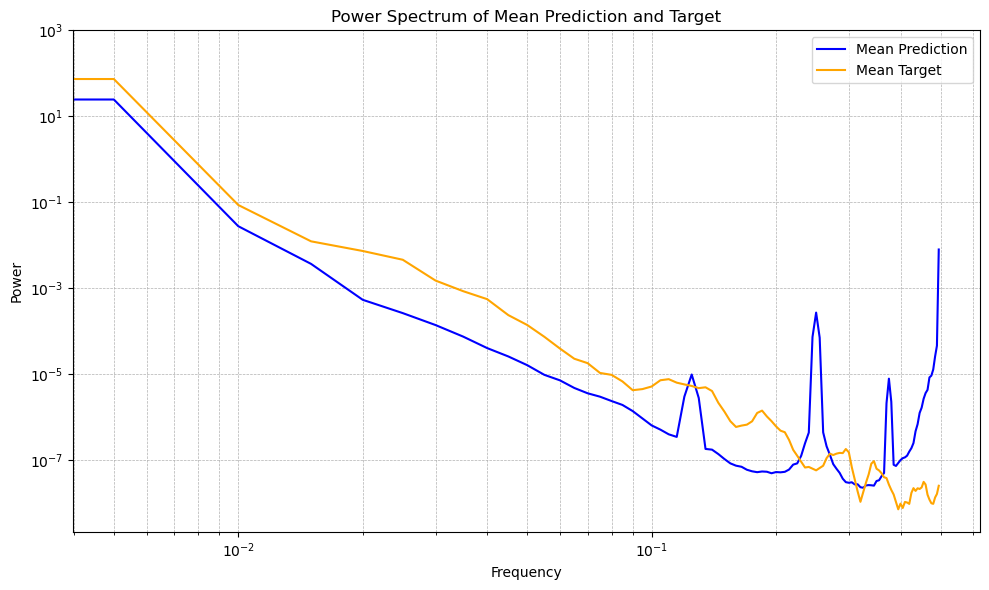

In [42]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),  # Replace with actual coordinates if available
    'xt_ocean': range(sr_pred.shape[-1])   # Replace with actual coordinates if available
}

# Compute the mean prediction and target across samples
mean_prediction = sr_pred.mean(dim='time')  # Squeeze to remove the channel dimension and compute mean
mean_target = urel_HR_test.mean(dim='time')

# Convert to xarray.DataArray
mean_prediction_da = xr.DataArray(mean_prediction, dims=dims, coords=coords)
mean_target_da = xr.DataArray(mean_target, dims=dims, coords=coords)

mean_prediction_da = mean_prediction_da.chunk({'xt_ocean': -1})  # one chunk along xt_ocean
mean_target_da = mean_target_da.chunk({'xt_ocean': -1})

# Compute power spectrum for mean prediction and target
ps_pred = xrft.power_spectrum(mean_prediction_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_targ = xrft.power_spectrum(mean_target_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Mean Prediction', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Mean Target', color='orange')

# Configure the plot
plt.title("Power Spectrum of Mean Prediction and Target")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()


# Robustness Test 2: Random Seed 2
## Remember to restart the kernel each time you do this! Or the tests won't be independent!

In [6]:
torch.manual_seed(10)

In [7]:
# Total number of samples
n_samples = len(ds_HR_reg.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
# np.random.shuffle(indices)     # THIS IS JUST FOR THIS RUN -- VERY NAIVE, DON'T DO THIS OUTSIDE THIS EXPERIMENT

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# HR
train_data_HR = ds_HR_reg.isel(time=train_indices)
val_data_HR = ds_HR_reg.isel(time=val_indices)
test_data_HR = ds_HR_reg.isel(time=test_indices)
# LR
train_data_LR = ds_LR_reg.isel(time=train_indices)
val_data_LR = ds_LR_reg.isel(time=val_indices)
test_data_LR = ds_LR_reg.isel(time=test_indices)

print("Training set size:", len(train_data_HR.time))
print("Validation set size:", len(val_data_HR.time))
print("Testing set size:", len(test_data_HR.time))

Training set size: 511
Validation set size: 109
Testing set size: 111


In [8]:
# Extract HR data
urel_HR_train = train_data_HR.u_relative.values ## training
urel_HR_val = val_data_HR.u_relative.values ## validation
urel_HR_test = test_data_HR.u_relative ## testing

# Extract LR data
urel_LR_train = train_data_LR.u_relative.values ## training
urel_LR_val = val_data_LR.u_relative.values ## validation
urel_LR_test = test_data_LR.u_relative.values ## testing

In [9]:
x_train = torch.tensor(urel_LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(urel_HR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(urel_LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(urel_HR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(urel_LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
# y_test = torch.tensor(urel_HR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [10]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, torch.zeros(len(x_test)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [11]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [12]:
criterion = CombinedLoss(alpha=1) # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_robustnessTrial2.pth',
            n_epochs=10) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 3.405e+01, Val Loss: 3.831e+01, Epoch Time: 308.93s
Model saved at epoch 1
Epoch 2, Train Loss: 2.791e+01, Val Loss: 2.933e+01, Epoch Time: 311.66s
Model saved at epoch 2
Epoch 3, Train Loss: 2.539e+01, Val Loss: 2.278e+01, Epoch Time: 313.19s
Model saved at epoch 3
Epoch 4, Train Loss: 2.317e+01, Val Loss: 2.141e+01, Epoch Time: 309.84s
Model saved at epoch 4
Epoch 5, Train Loss: 2.105e+01, Val Loss: 1.993e+01, Epoch Time: 311.88s
Model saved at epoch 5
Epoch 6, Train Loss: 1.911e+01, Val Loss: 1.826e+01, Epoch Time: 311.36s
Model saved at epoch 6
Epoch 7, Train Loss: 1.739e+01, Val Loss: 1.528e+01, Epoch Time: 311.27s
Model saved at epoch 7
Epoch 8, Train Loss: 1.543e+01, Val Loss: 1.323e+01, Epoch Time: 310.75s
Model saved at epoch 8
Epoch 9, Train Loss: 1.369e+01, Val Loss: 1.073e+01, Epoch Time: 308.11s
Model saved at epoch 9
Epoch 10, Train Loss: 1.212e+01, Val Loss: 1.038e+01, Epoch Time: 312.13s
Model saved at epoch 10
Training

In [13]:
sr_pred = evaluate_model_sr(model, device, test_loader, urel_HR_test, './model_robustnessTrial2.pth')
sr_pred

Loaded model parameters from ./model_robustnessTrial2.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[ -2.6837537 ,  -3.6760287 ,  -3.6519492 , ...,  -2.569296  ,
          -2.7865024 ,  -1.4715782 ],
        [ -3.4656343 ,  -3.4609926 ,  -3.3684993 , ...,  -2.5366325 ,
          -3.8238916 ,  -1.8772761 ],
        [ -3.665809  ,  -3.992839  ,  -3.6335247 , ...,  -2.5130699 ,
          -4.522254  ,  -2.4547284 ],
        ...,
        [  5.78298   ,   6.024437  ,   6.1300545 , ...,   6.751194  ,
          11.683691  ,   6.443965  ],
        [  7.427034  ,   9.107834  ,   9.866939  , ...,  10.814264  ,
          14.110743  ,   7.5653324 ],
        [  4.0937543 ,   5.2873383 ,   5.9430094 , ...,   6.9263496 ,
           8.932692  ,   4.7225847 ]],

       [[  0.0705162 ,   0.03797887,  -0.1688042 , ...,  -5.8699923 ,
          -6.169449  ,  -3.6455433 ],
        [  0.10745583,   0.19547652,   0.11033137, ...,  -5.950195  ,
          -7.9348307 ,  -4.433359  ],
        [  0.14202914,   0.21749905,   0.182751  , ...,  -5.9937105 ,
          -9.498314  ,  -5.711401  ],
...
           0.18628955,   0.19861102],
        [  0.21749906,   0.21749906,   0.10525773, ...,   0.2120543 ,
           0.09339145,   0.15432419],
        [  0.21749906,   0.21749906,   0.12196134, ...,   0.20490864,
           0.15619025,   0.18909974]],

       [[  0.21749906,   0.21749906,   0.21749906, ...,  -3.1946113 ,
          -3.4007654 ,  -1.8868043 ],
        [  0.21749906,   0.21749906,   0.21749906, ...,  -3.123421  ,
          -4.5071397 ,  -2.329791  ],
        [  0.21749906,   0.21749906,   0.21749906, ...,  -3.076162  ,
          -5.294937  ,  -2.9857948 ],
        ...,
        [ -1.8884336 ,  -2.0530944 ,  -2.3052895 , ...,   4.0285125 ,
           7.218535  ,   3.9958644 ],
        [ -2.5173454 ,  -3.2696579 ,  -4.1877627 , ...,   6.68556   ,
           8.842257  ,   4.6487436 ],
        [ -1.2427113 ,  -1.9796226 ,  -2.4729676 , ...,   4.1757426 ,
           5.4968967 ,   3.01391   ]]],
      shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0197-12-23 12:00:00 ... 0200-12-27 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

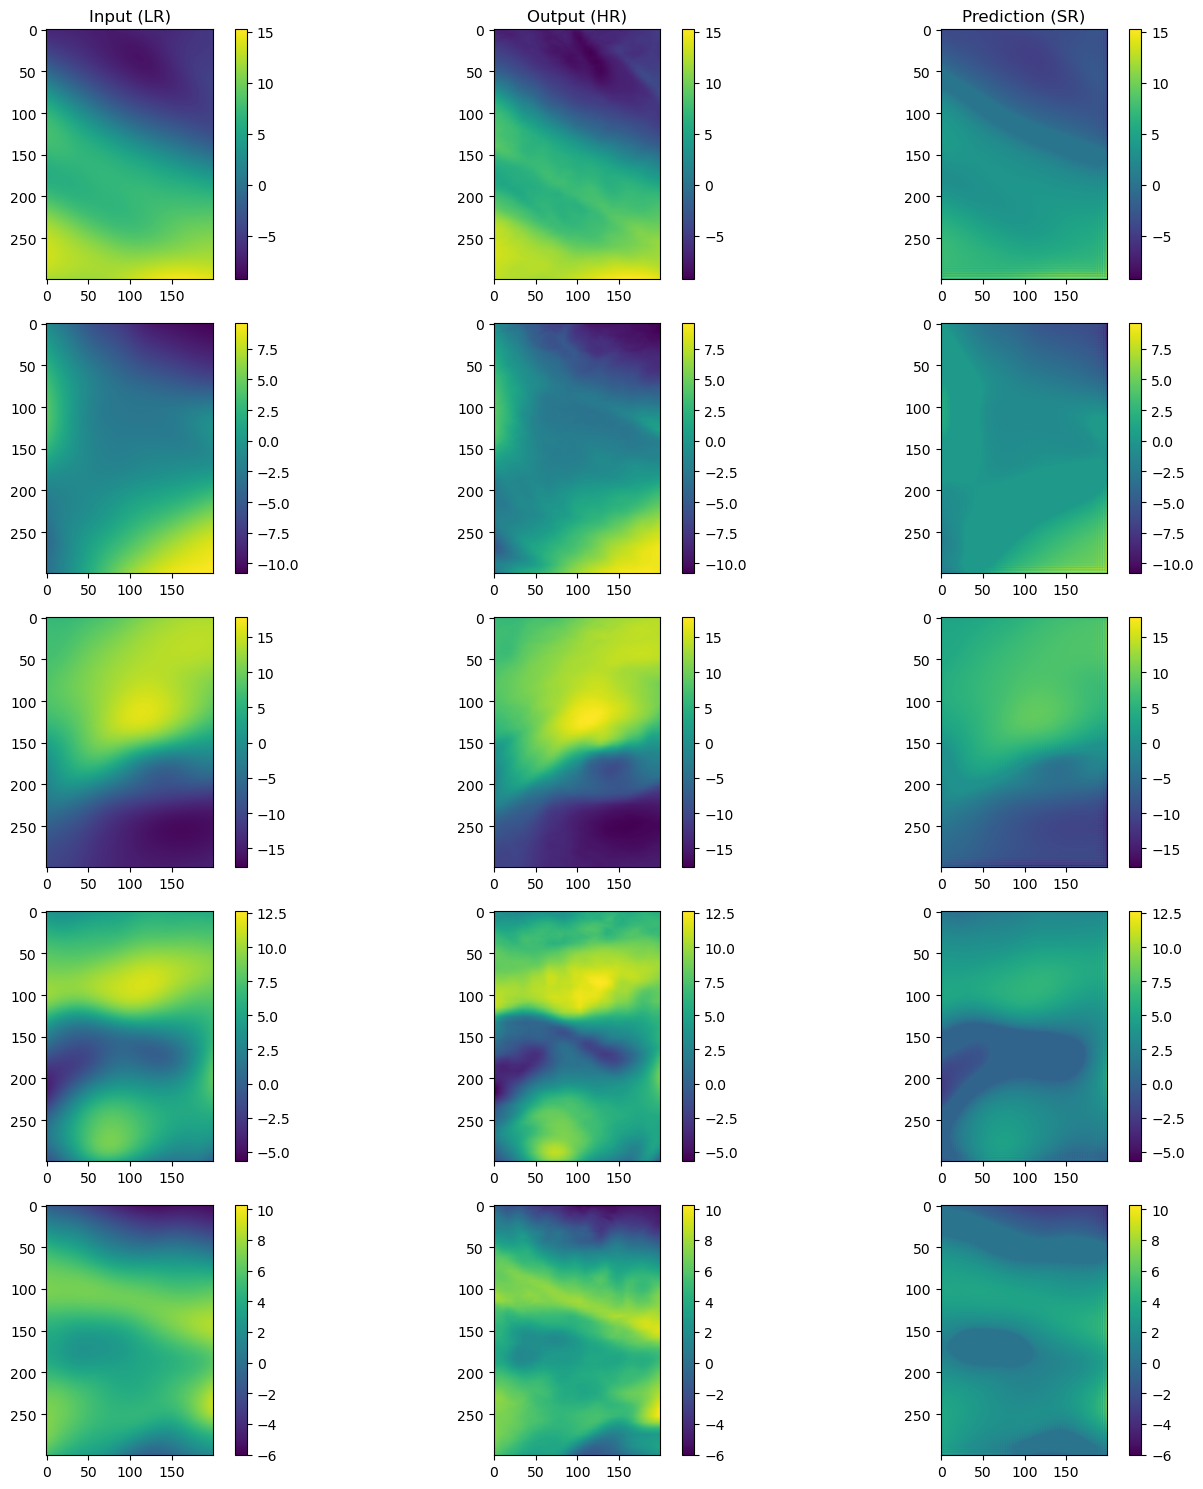

In [14]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = urel_LR_test[i,:,:] 
    d2 = urel_HR_test[i,:,:]
    d3 = sr_pred[i,:,:]

    # Min/Max Calculation
    vmin = min(d1.min().item(), d2.min().compute().item(), d3.min().compute().item())
    vmax = max(d1.max().item(), d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('Output (HR)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 2].set_title('Prediction (SR)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

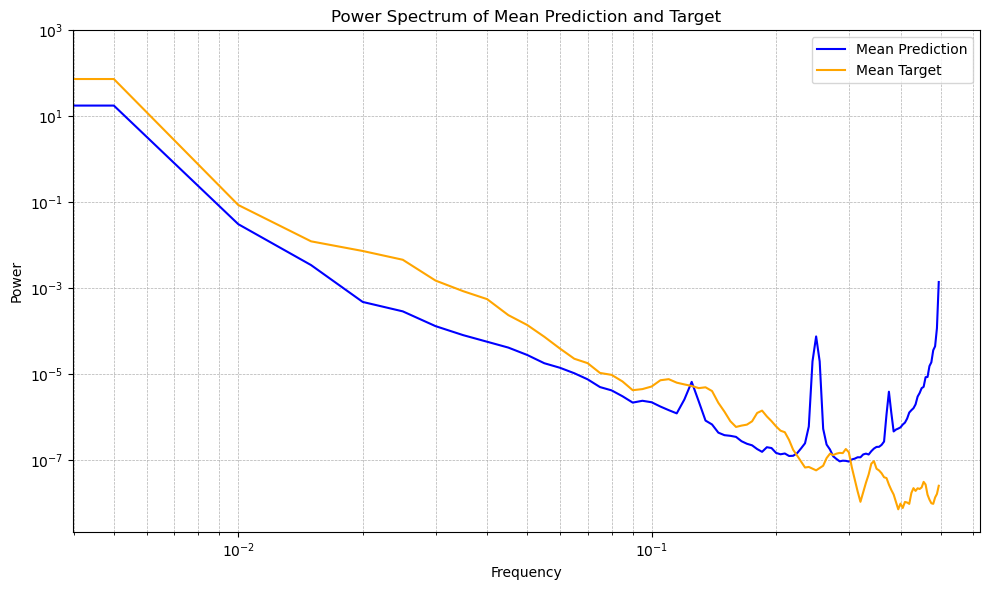

In [15]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),  # Replace with actual coordinates if available
    'xt_ocean': range(sr_pred.shape[-1])   # Replace with actual coordinates if available
}

# Compute the mean prediction and target across samples
mean_prediction = sr_pred.mean(dim='time')  # Squeeze to remove the channel dimension and compute mean
mean_target = urel_HR_test.mean(dim='time')

# Convert to xarray.DataArray
mean_prediction_da = xr.DataArray(mean_prediction, dims=dims, coords=coords)
mean_target_da = xr.DataArray(mean_target, dims=dims, coords=coords)

mean_prediction_da = mean_prediction_da.chunk({'xt_ocean': -1})  # one chunk along xt_ocean
mean_target_da = mean_target_da.chunk({'xt_ocean': -1})

# Compute power spectrum for mean prediction and target
ps_pred = xrft.power_spectrum(mean_prediction_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_targ = xrft.power_spectrum(mean_target_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Mean Prediction', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Mean Target', color='orange')

# Configure the plot
plt.title("Power Spectrum of Mean Prediction and Target")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()


# Robustness Test 3: Random Seed 3
## Remember to restart the kernel each time you do this! Or the tests won't be independent!

In [6]:
torch.manual_seed(52)

In [7]:
# Total number of samples
n_samples = len(ds_HR_reg.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
# np.random.shuffle(indices)     # THIS IS JUST FOR THIS RUN -- VERY NAIVE, DON'T DO THIS OUTSIDE THIS EXPERIMENT

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# HR
train_data_HR = ds_HR_reg.isel(time=train_indices)
val_data_HR = ds_HR_reg.isel(time=val_indices)
test_data_HR = ds_HR_reg.isel(time=test_indices)
# LR
train_data_LR = ds_LR_reg.isel(time=train_indices)
val_data_LR = ds_LR_reg.isel(time=val_indices)
test_data_LR = ds_LR_reg.isel(time=test_indices)

print("Training set size:", len(train_data_HR.time))
print("Validation set size:", len(val_data_HR.time))
print("Testing set size:", len(test_data_HR.time))

Training set size: 511
Validation set size: 109
Testing set size: 111


In [8]:
# Extract HR data
urel_HR_train = train_data_HR.u_relative.values ## training
urel_HR_val = val_data_HR.u_relative.values ## validation
urel_HR_test = test_data_HR.u_relative ## testing

# Extract LR data
urel_LR_train = train_data_LR.u_relative.values ## training
urel_LR_val = val_data_LR.u_relative.values ## validation
urel_LR_test = test_data_LR.u_relative.values ## testing

In [9]:
x_train = torch.tensor(urel_LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(urel_HR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(urel_LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(urel_HR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(urel_LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
# y_test = torch.tensor(urel_HR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [10]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, torch.zeros(len(x_test)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [11]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [12]:
criterion = CombinedLoss(alpha=1) # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_robustnessTrial3.pth',
            n_epochs=10) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 3.238e+01, Val Loss: 3.521e+01, Epoch Time: 307.86s
Model saved at epoch 1
Epoch 2, Train Loss: 2.626e+01, Val Loss: 2.664e+01, Epoch Time: 311.92s
Model saved at epoch 2
Epoch 3, Train Loss: 2.373e+01, Val Loss: 2.194e+01, Epoch Time: 311.94s
Model saved at epoch 3
Epoch 4, Train Loss: 2.163e+01, Val Loss: 1.974e+01, Epoch Time: 311.59s
Model saved at epoch 4
Epoch 5, Train Loss: 1.957e+01, Val Loss: 1.857e+01, Epoch Time: 309.64s
Model saved at epoch 5
Epoch 6, Train Loss: 1.777e+01, Val Loss: 1.600e+01, Epoch Time: 308.07s
Model saved at epoch 6
Epoch 7, Train Loss: 1.596e+01, Val Loss: 1.526e+01, Epoch Time: 309.82s
Model saved at epoch 7
Epoch 8, Train Loss: 1.422e+01, Val Loss: 1.299e+01, Epoch Time: 311.80s
Model saved at epoch 8
Epoch 9, Train Loss: 1.264e+01, Val Loss: 1.178e+01, Epoch Time: 310.46s
Model saved at epoch 9
Epoch 10, Train Loss: 1.136e+01, Val Loss: 1.021e+01, Epoch Time: 308.58s
Model saved at epoch 10
Training

In [13]:
sr_pred = evaluate_model_sr(model, device, test_loader, urel_HR_test, './model_robustnessTrial3.pth')
sr_pred

Loaded model parameters from ./model_robustnessTrial3.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[ -2.1870878 ,  -3.2891102 ,  -4.0705705 , ...,  -3.5866752 ,
          -3.9952717 ,  -2.5588825 ],
        [ -3.0679867 ,  -3.8357146 ,  -4.0632153 , ...,  -3.3854578 ,
          -4.842307  ,  -2.8564665 ],
        [ -3.499769  ,  -4.1595035 ,  -4.203202  , ...,  -3.457955  ,
          -4.8667307 ,  -2.9369445 ],
        ...,
        [  5.6957073 ,   6.594806  ,   6.1475005 , ...,   7.444907  ,
          11.987539  ,   6.930484  ],
        [  7.061921  ,   9.75349   ,   9.713729  , ...,  12.3652    ,
          14.900808  ,   8.98461   ],
        [  3.5134394 ,   4.51254   ,   5.2269077 , ...,   7.0475674 ,
           8.929393  ,   5.746538  ]],

       [[  0.15733598,   0.11177479,  -0.04987344, ...,  -7.4875865 ,
          -8.480937  ,  -5.53758   ],
        [  0.19078298,   0.2584239 ,   0.18695858, ...,  -7.033247  ,
         -10.331651  ,  -6.320751  ],
        [  0.24517947,   0.30684686,   0.25560072, ...,  -7.2393923 ,
         -10.098634  ,  -6.351931  ],
...
           0.32454142,   0.32454142],
        [  0.32202458,   0.32454142,   0.32454142, ...,   0.32454142,
           0.34498334,   0.32454142],
        [  0.22116427,   0.31498367,   0.3188527 , ...,   0.28921264,
           0.26158547,   0.2623943 ]],

       [[  0.32723656,   0.32454142,   0.32454142, ...,  -4.2642326 ,
          -4.7816796 ,  -3.0923004 ],
        [  0.32454142,   0.32454142,   0.32454142, ...,  -3.9496374 ,
          -5.7133217 ,  -3.432747  ],
        [  0.32454142,   0.32454142,   0.32454142, ...,  -3.951794  ,
          -5.605563  ,  -3.4407876 ],
        ...,
        [ -2.417809  ,  -2.616571  ,  -3.0091825 , ...,   4.621977  ,
           7.7021284 ,   4.4290366 ],
        [ -2.6908772 ,  -3.336339  ,  -3.9249244 , ...,   7.7511444 ,
           9.554525  ,   5.6916933 ],
        [ -1.8643639 ,  -2.3598294 ,  -2.5649884 , ...,   4.403253  ,
           5.716035  ,   3.5236714 ]]],
      shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0197-12-23 12:00:00 ... 0200-12-27 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

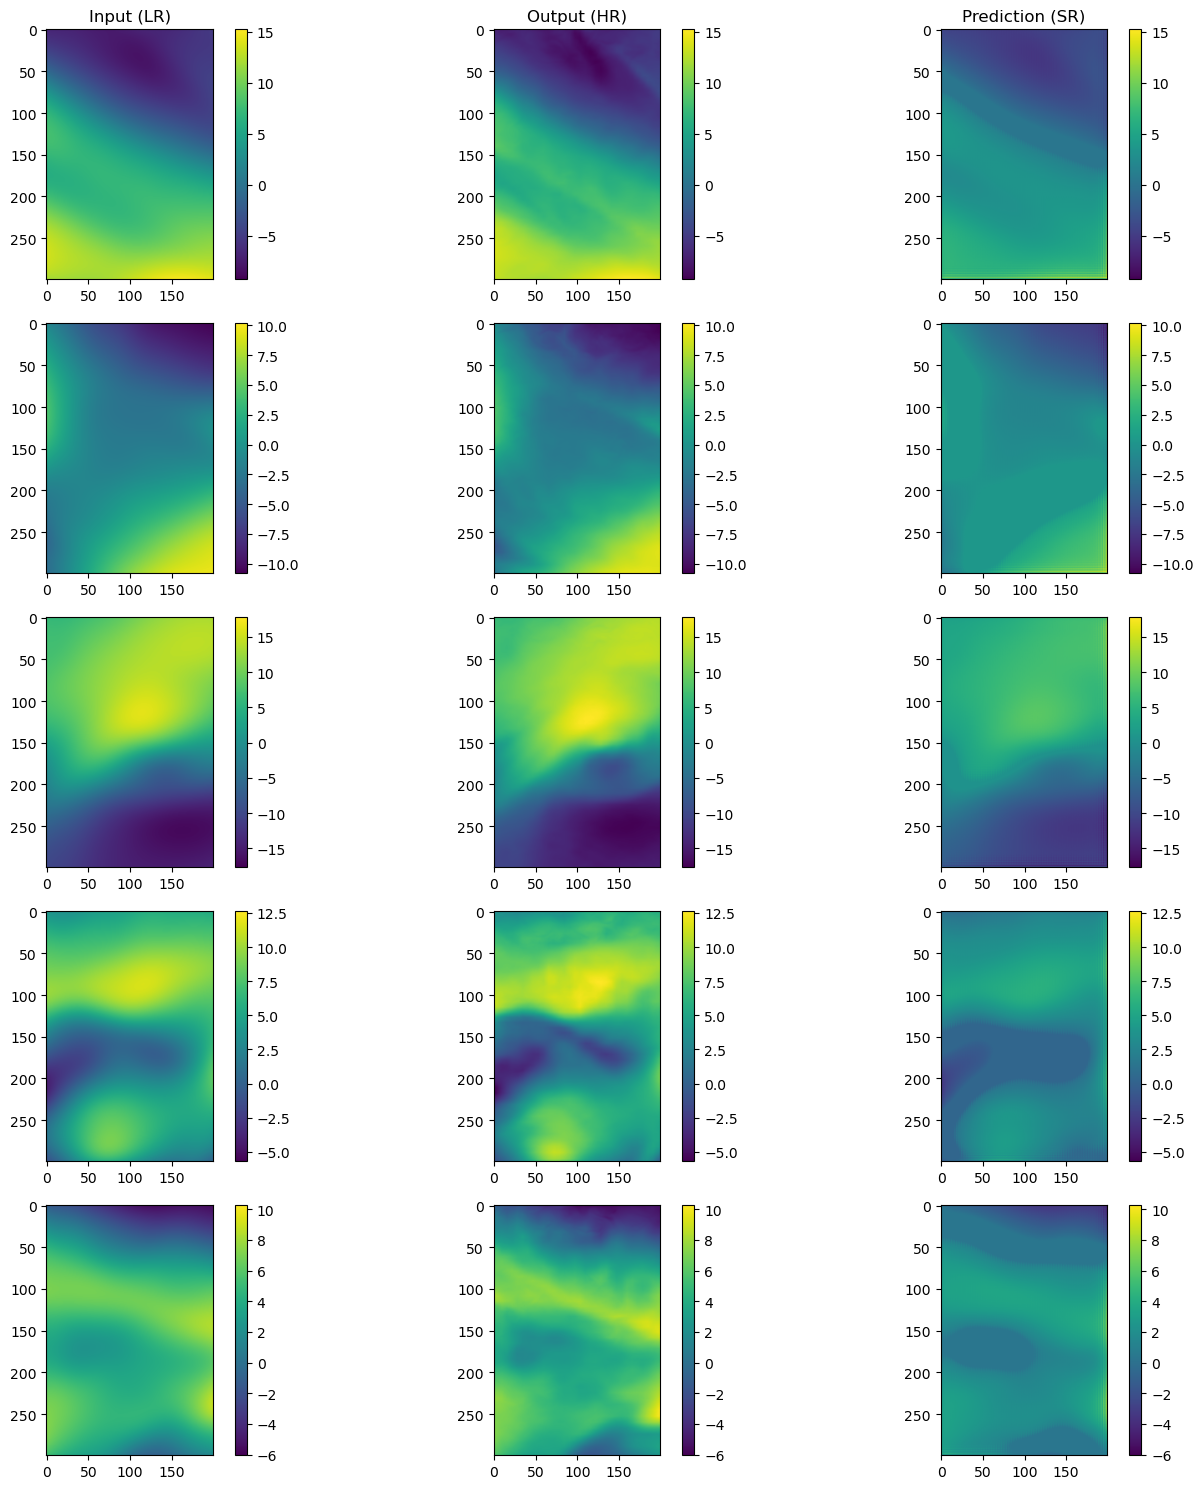

In [14]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = urel_LR_test[i,:,:] 
    d2 = urel_HR_test[i,:,:]
    d3 = sr_pred[i,:,:]

    # Min/Max Calculation
    vmin = min(d1.min().item(), d2.min().compute().item(), d3.min().compute().item())
    vmax = max(d1.max().item(), d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('Output (HR)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 2].set_title('Prediction (SR)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

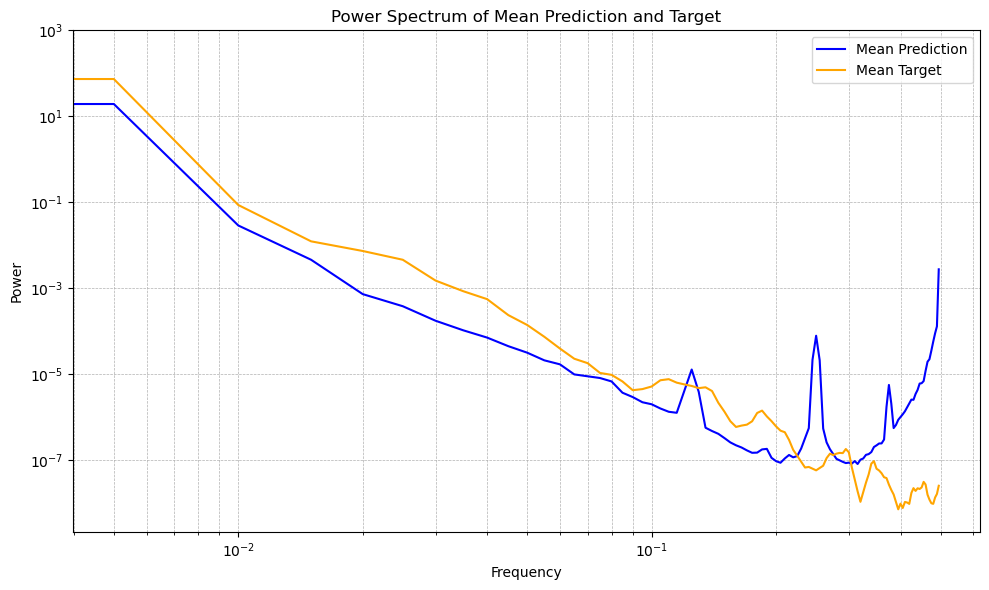

In [15]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),  # Replace with actual coordinates if available
    'xt_ocean': range(sr_pred.shape[-1])   # Replace with actual coordinates if available
}

# Compute the mean prediction and target across samples
mean_prediction = sr_pred.mean(dim='time')  # Squeeze to remove the channel dimension and compute mean
mean_target = urel_HR_test.mean(dim='time')

# Convert to xarray.DataArray
mean_prediction_da = xr.DataArray(mean_prediction, dims=dims, coords=coords)
mean_target_da = xr.DataArray(mean_target, dims=dims, coords=coords)

mean_prediction_da = mean_prediction_da.chunk({'xt_ocean': -1})  # one chunk along xt_ocean
mean_target_da = mean_target_da.chunk({'xt_ocean': -1})

# Compute power spectrum for mean prediction and target
ps_pred = xrft.power_spectrum(mean_prediction_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_targ = xrft.power_spectrum(mean_target_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Mean Prediction', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Mean Target', color='orange')

# Configure the plot
plt.title("Power Spectrum of Mean Prediction and Target")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()
